------
# PREPARAR LOS DATOS

In [1]:
!wget -O CSVORIGINAL.csv https://raw.githubusercontent.com/SergioMartinezCid/MUII-DSI-2022-23/master/Clustering/CSVORIGINAL.csv

--2023-05-06 08:26:25--  https://raw.githubusercontent.com/SergioMartinezCid/MUII-DSI-2022-23/master/Clustering/CSVORIGINAL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350830 (343K) [text/plain]
Saving to: ‘CSVORIGINAL.csv’

CSVORIGINAL.csv     100%[===================>] 342.61K  --.-KB/s    in 0.02s   

2023-05-06 08:26:25 (15.3 MB/s) - ‘CSVORIGINAL.csv’ saved [350830/350830]



## Importación y limpieza inicial de los datos

In [2]:
#Instalar librerias para dibujar la red gráficamente
!pip install pydot
!apt-get install graphviz
# Imports
import pandas as pd
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CategoryEncoding, Lambda
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [3]:
# Fijamos el estado aleatorio del algoritmo para obtener resultados repetibles
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)

In [4]:
original_df = pd.read_csv('CSVORIGINAL.csv', delimiter='\t', decimal=',')

# Se borra la última fila, que es nula
original_df = original_df.drop(3071, axis=0)

# Eliminamos prod100 y scoring por ser datos agregados
original_df = original_df.drop(['prod100', 'scoring'], axis=1)
# Eliminamos las tarjetas por no ser relevantes
original_df = original_df.drop(['YC', 'RC', 'BC'], axis=1)
original_df = original_df.drop(['Time', 'No.', 'Match No.'], axis=1)
# Comprobamos si ha quedado algún valor nulo
print(original_df.isnull().values.any())

# Sumamos los goles
original_df['GOALS'] = original_df['7mGoals'] + original_df['6mGoals'] + original_df['WingGoals']+original_df['BTGoals']+original_df['FBGoals']+original_df['EGGoals']+original_df['9mGoals']

#Agrupamos por equipo y partido
original_df = original_df.groupby(['Match','Team'], as_index=False).sum()
original_df.head()

False


<ipython-input-4-0c9aaef5dcf8>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  original_df = original_df.groupby(['Match','Team'], as_index=False).sum()


,Match,Team,7mGoals,7mMissed,6mGoals,6mMissed,WingGoals,WingMissed,BTGoals,BTMissed,...,EGGoals,EGMissed,9mGoals,9mMissed,TF,2Min,AS,ST,BS,GOALS
0,ALG-ISL,ALG,4.0,0.0,6.0,1.0,3.0,4.0,5.0,3.0,...,2.0,1.0,4.0,14.0,6.0,4.0,7.0,3.0,0.0,24.0
1,ALG-ISL,ISL,7.0,0.0,5.0,2.0,8.0,3.0,5.0,0.0,...,2.0,0.0,8.0,1.0,3.0,4.0,18.0,3.0,3.0,39.0
2,ALG-MAR,ALG,1.0,4.0,6.0,1.0,5.0,4.0,4.0,1.0,...,2.0,0.0,4.0,11.0,15.0,6.0,8.0,8.0,1.0,24.0
3,ALG-MAR,MAR,4.0,0.0,4.0,5.0,3.0,3.0,1.0,6.0,...,1.0,0.0,5.0,4.0,16.0,9.0,12.0,5.0,5.0,23.0
4,ALG-SUI,ALG,1.0,1.0,5.0,3.0,2.0,2.0,5.0,1.0,...,1.0,0.0,8.0,12.0,8.0,3.0,8.0,0.0,2.0,24.0


## Obtener los partidos y sus resultados

In [5]:
#Lo pivotamos para poder sacar más facilmente los resultados de cada partido
pivoted_df = original_df.copy()
pivoted_df['TeamNames']=pivoted_df['Match']

#Sacamos los nombres de los equipos por separado
pivoted_df[['Team1','Team2']] = pivoted_df['TeamNames'].str.split('-',expand=True)
pivoted_df[['Team1','Team2']] = pd.DataFrame(np.sort(pivoted_df[['Team1','Team2']].values, axis=1))

#Podemos droppear Match porque ya tenemos Team1 y Team2
pivoted_df = pivoted_df.drop(['Match', 'TeamNames'], axis=1)

pivoted_df = pivoted_df.pivot_table(index=['Team1', 'Team2'], columns='Team', values=['GOALS'])
pivoted_df

GOALS                                      ...                  \
Team          ALG ANG ARG AUT BLR BRA BRN CHI COD CPV  ...   NOR POL   POR   
Team1 Team2                                            ...                   
ALG   FRA    26.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   
      ISL    24.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   
      MAR    24.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   
      NOR    23.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  36.0 NaN   NaN   
      POR    19.0 NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN  26.0   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...  ..   ...   
POR   SUI     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN  33.0   
QAT   SWE     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   
RHF   SLO     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   
      SWE     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   
SLO   SWE     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN NaN   NaN   

                                                   
Team          QAT   RHF   SLO   SUI   SWE TUN URU  
Team1 Team2                                        
ALG   FRA     NaN   NaN   NaN   NaN   NaN NaN NaN  
      ISL     NaN   NaN   NaN   NaN   NaN NaN NaN  
      MAR     NaN   NaN   NaN   NaN   NaN NaN NaN  
      NOR     NaN   NaN   NaN   NaN   NaN NaN NaN  
      POR     NaN   NaN   NaN   NaN   NaN NaN NaN  
...           ...   ...   ...   ...   ...  ..  ..  
POR   SUI     NaN   NaN   NaN  29.0   NaN NaN NaN  
QAT   SWE    23.0   NaN   NaN   NaN  35.0 NaN NaN  
RHF   SLO     NaN  31.0  25.0   NaN   NaN NaN NaN  
      SWE     NaN  20.0   NaN   NaN  34.0 NaN NaN  
SLO   SWE     NaN   NaN  28.0   NaN  28.0 NaN NaN  

[96 rows x 32 columns]

In [6]:
def replace_with_list(x):
    if pd.isna(x):
        return []
    else:
        return [x]
def get_n_el(i):
  def result(x):
    return x[i]
  return result

In [7]:
df_builder = dict()

# Team1 is the first team in alphabetical order, while Team2 is the second
combined_columns = pivoted_df['GOALS'].applymap(replace_with_list).sum(axis=1)
df_builder['GOALS_Team1'] = combined_columns.apply(get_n_el(0))
df_builder['GOALS_Team2'] = combined_columns.apply(get_n_el(1))

combined_df = pd.DataFrame(df_builder)
combined_df['GOALS_DIFF'] = combined_df['GOALS_Team1'] - combined_df['GOALS_Team2']
combined_df

GOALS_Team1  GOALS_Team2  GOALS_DIFF
Team1 Team2                                      
ALG   FRA           26.0         29.0        -3.0
      ISL           24.0         39.0       -15.0
      MAR           24.0         23.0         1.0
      NOR           23.0         36.0       -13.0
      POR           19.0         26.0        -7.0
...                  ...          ...         ...
POR   SUI           33.0         29.0         4.0
QAT   SWE           23.0         35.0       -12.0
RHF   SLO           31.0         25.0         6.0
      SWE           20.0         34.0       -14.0
SLO   SWE           28.0         28.0         0.0

[96 rows x 3 columns]

## Separar en conjunto de entrenamiento y test

Separamos los partidos de test que se indican en el enunciado.

In [8]:
#Dividimos los datos en datos de prueba y datos de test
test_df = pd.concat([
    combined_df.loc[(['GER'],['URU']),:],
    combined_df.loc[(['CPV'],['HUN']),:],
    combined_df.loc[(['HUN'],['URU']),:],
    combined_df.loc[(['GER'],['HUN']),:],
    combined_df.loc[(['BRA'],['ESP']),:],
    combined_df.loc[(['POL'],['TUN']),:],
    combined_df.loc[(['BRA'],['TUN']),:],
    combined_df.loc[(['ESP'],['POL']),:],
    combined_df.loc[(['ESP'],['TUN']),:],
    combined_df.loc[(['BRA'],['POL']),:],
    combined_df.loc[(['ANG'],['QAT']),:],
    combined_df.loc[(['CRO'],['JPN']),:],
    combined_df.loc[(['JPN'],['QAT']),:],
    combined_df.loc[(['ANG'],['CRO']),:],
    combined_df.loc[(['ANG'],['JPN']),:],
    combined_df.loc[(['CRO'],['QAT']),:],
    combined_df.loc[(['ARG'],['COD']),:],
    combined_df.loc[(['BRN'],['DEN']),:],
    combined_df.loc[(['ARG'],['BRN']),:],
    combined_df.loc[(['COD'],['DEN']),:],
    combined_df.loc[(['BRN'],['COD']),:],
    combined_df.loc[(['ARG'],['DEN']),:]
])
missing_matches_dict = {'Team1': ['CPV', 'CPV'], 'Team2': ['GER', 'URU'], 'GOALS_Team1': [0, 0], 'GOALS_Team2': [10, 10], 'GOALS_DIFF': [-10, -10]}
missing_matches_df = pd.DataFrame(missing_matches_dict)
missing_matches_df.set_index(['Team1', 'Team2'], inplace=True)
test_df = pd.concat([test_df, missing_matches_df])

combined_df_tmp = combined_df.copy().reset_index(level=[0, 1])
train_df = pd.merge(combined_df_tmp,test_df, indicator=True, how='left').set_index(['Team1', 'Team2']).query('_merge=="left_only"').drop('_merge', axis=1)

In [9]:
test_df

GOALS_Team1  GOALS_Team2  GOALS_DIFF
Team1 Team2                                      
GER   URU           43.0         14.0        29.0
CPV   HUN           27.0         34.0        -7.0
HUN   URU           44.0         18.0        26.0
GER   HUN           28.0         29.0        -1.0
BRA   ESP           29.0         29.0         0.0
POL   TUN           30.0         28.0         2.0
BRA   TUN           32.0         33.0        -1.0
ESP   POL           27.0         26.0         1.0
      TUN           36.0         30.0         6.0
BRA   POL           23.0         33.0       -10.0
ANG   QAT           25.0         30.0        -5.0
CRO   JPN           29.0         29.0         0.0
JPN   QAT           29.0         31.0        -2.0
ANG   CRO           20.0         28.0        -8.0
      JPN           29.0         30.0        -1.0
CRO   QAT           26.0         24.0         2.0
ARG   COD           28.0         22.0         6.0
BRN   DEN           20.0         34.0       -14.0
ARG   BRN           24.0         21.0         3.0
COD   DEN           19.0         39.0       -20.0
BRN   COD           34.0         27.0         7.0
ARG   DEN           20.0         31.0       -11.0
CPV   GER            0.0         10.0       -10.0
      URU            0.0         10.0       -10.0

In [10]:
train_df.head()

GOALS_Team1  GOALS_Team2  GOALS_DIFF
Team1 Team2                                      
ALG   FRA           26.0         29.0        -3.0
      ISL           24.0         39.0       -15.0
      MAR           24.0         23.0         1.0
      NOR           23.0         36.0       -13.0
      POR           19.0         26.0        -7.0

## Obtener las medias de los equipos por partido

In [11]:
#Agrupamos por equipo sacando las medias y percentiles por equipo
training_matches = ['-'.join(match_) for match_ in train_df.index] + ['-'.join(match_[::-1]) for match_ in train_df.index]
medias_df = original_df.copy()
medias_df = medias_df[medias_df['Match'].isin(training_matches)]
medias_df = medias_df.drop(['Match', 'GOALS'], axis=1)
medias_df = medias_df.groupby(['Team'], as_index=True).describe()
medias_df.columns = medias_df.columns.to_flat_index()
medias_df.drop(columns=[column for column in medias_df.columns if column[1] in ['count', 'std']], inplace=True)
medias_df.columns = ['_'.join(col) for col in medias_df.columns]
medias_df.head()

,7mGoals_mean,7mGoals_min,7mGoals_25%,7mGoals_50%,7mGoals_75%,7mGoals_max,7mMissed_mean,7mMissed_min,7mMissed_25%,7mMissed_50%,...,ST_25%,ST_50%,ST_75%,ST_max,BS_mean,BS_min,BS_25%,BS_50%,BS_75%,BS_max
Team,,,,,,,,,,,,,,,,,,,,,
ALG,2.666667,1.0,1.50,3.0,3.75,4.0,1.000000,0.0,0.00,0.5,...,1.5,3.5,4.75,8.0,0.500000,0.0,0.00,0.0,0.75,2.0
ANG,3.500000,2.0,2.75,3.5,4.25,5.0,1.500000,1.0,1.25,1.5,...,5.0,5.0,5.00,5.0,0.500000,0.0,0.25,0.5,0.75,1.0
ARG,1.500000,1.0,1.25,1.5,1.75,2.0,0.500000,0.0,0.25,0.5,...,2.0,2.0,2.00,2.0,0.500000,0.0,0.25,0.5,0.75,1.0
AUT,3.428571,1.0,2.00,4.0,5.00,5.0,0.857143,0.0,0.00,0.0,...,3.5,4.0,6.50,8.0,1.714286,0.0,1.00,1.0,2.00,5.0
BLR,1.500000,0.0,0.25,1.0,1.75,5.0,0.333333,0.0,0.00,0.0,...,0.5,2.5,3.00,4.0,2.166667,2.0,2.00,2.0,2.00,3.0


## Combinar ambos datos

In [12]:
#Añadimos los datos de las medias de los equipos a la tabla con los resultados de los partidos (train)
train_df = train_df.reset_index()
train_df = train_df.merge(medias_df, left_on='Team1', right_on='Team')
train_df = train_df.merge(medias_df, left_on='Team2', right_on='Team', suffixes=('_Team1', '_Team2'))
train_df

,Team1,Team2,GOALS_Team1,GOALS_Team2,GOALS_DIFF,7mGoals_mean_Team1,7mGoals_min_Team1,7mGoals_25%_Team1,7mGoals_50%_Team1,7mGoals_75%_Team1,...,ST_25%_Team2,ST_50%_Team2,ST_75%_Team2,ST_max_Team2,BS_mean_Team2,BS_min_Team2,BS_25%_Team2,BS_50%_Team2,BS_75%_Team2,BS_max_Team2
0,ALG,FRA,26.0,29.0,-3.0,2.666667,1.0,1.5,3.0,3.75,...,1.00,3.0,4.0,5.0,2.333333,0.0,2.00,2.0,3.0,5.0
1,AUT,FRA,28.0,35.0,-7.0,3.428571,1.0,2.0,4.0,5.00,...,1.00,3.0,4.0,5.0,2.333333,0.0,2.00,2.0,3.0,5.0
2,ESP,FRA,35.0,29.0,6.0,1.800000,1.0,1.0,2.0,2.00,...,1.00,3.0,4.0,5.0,2.333333,0.0,2.00,2.0,3.0,5.0
3,ALG,ISL,24.0,39.0,-15.0,2.666667,1.0,1.5,3.0,3.75,...,2.25,3.5,5.5,6.0,2.166667,0.0,1.25,2.5,3.0,4.0
4,FRA,ISL,28.0,26.0,2.0,2.666667,1.0,2.0,2.0,3.00,...,2.25,3.5,5.5,6.0,2.166667,0.0,1.25,2.5,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,DEN,ESP,35.0,33.0,2.0,6.000000,2.0,4.0,6.0,8.00,...,5.00,6.0,6.0,9.0,2.200000,1.0,1.00,1.0,2.0,6.0
66,ESP,HUN,36.0,28.0,8.0,1.800000,1.0,1.0,2.0,2.00,...,4.50,5.0,5.5,6.0,3.000000,2.0,2.50,3.0,3.5,4.0
67,FRA,HUN,35.0,32.0,3.0,2.666667,1.0,2.0,2.0,3.00,...,4.50,5.0,5.5,6.0,3.000000,2.0,2.50,3.0,3.5,4.0
68,GER,POL,23.0,23.0,0.0,2.000000,1.0,1.5,2.0,2.50,...,4.00,4.0,4.0,4.0,2.000000,2.0,2.00,2.0,2.0,2.0


In [13]:
#Añadimos los datos de las medias de los equipos a la tabla con los resultados de los partidos (test)
test_df = test_df.reset_index()
test_df = test_df.merge(medias_df, left_on='Team1', right_on='Team')
test_df = test_df.merge(medias_df, left_on='Team2', right_on='Team', suffixes=('_Team1', '_Team2'))
test_df

,Team1,Team2,GOALS_Team1,GOALS_Team2,GOALS_DIFF,7mGoals_mean_Team1,7mGoals_min_Team1,7mGoals_25%_Team1,7mGoals_50%_Team1,7mGoals_75%_Team1,...,ST_25%_Team2,ST_50%_Team2,ST_75%_Team2,ST_max_Team2,BS_mean_Team2,BS_min_Team2,BS_25%_Team2,BS_50%_Team2,BS_75%_Team2,BS_max_Team2
0,GER,URU,43.0,14.0,29.0,2.000000,1.0,1.50,2.0,2.50,...,3.50,4.0,4.50,5.0,0.000000,0.0,0.00,0.0,0.00,0.0
1,HUN,URU,44.0,18.0,26.0,2.666667,2.0,2.50,3.0,3.00,...,3.50,4.0,4.50,5.0,0.000000,0.0,0.00,0.0,0.00,0.0
2,GER,HUN,28.0,29.0,-1.0,2.000000,1.0,1.50,2.0,2.50,...,4.50,5.0,5.50,6.0,3.000000,2.0,2.50,3.0,3.50,4.0
3,BRA,ESP,29.0,29.0,0.0,1.500000,1.0,1.25,1.5,1.75,...,5.00,6.0,6.00,9.0,2.200000,1.0,1.00,1.0,2.00,6.0
4,BRA,TUN,32.0,33.0,-1.0,1.500000,1.0,1.25,1.5,1.75,...,3.50,4.0,7.00,10.0,1.333333,1.0,1.00,1.0,1.50,2.0
5,POL,TUN,30.0,28.0,2.0,2.000000,1.0,1.50,2.0,2.50,...,3.50,4.0,7.00,10.0,1.333333,1.0,1.00,1.0,1.50,2.0
6,ESP,TUN,36.0,30.0,6.0,1.800000,1.0,1.00,2.0,2.00,...,3.50,4.0,7.00,10.0,1.333333,1.0,1.00,1.0,1.50,2.0
7,BRA,POL,23.0,33.0,-10.0,1.500000,1.0,1.25,1.5,1.75,...,4.00,4.0,4.00,4.0,2.000000,2.0,2.00,2.0,2.00,2.0
8,ESP,POL,27.0,26.0,1.0,1.800000,1.0,1.00,2.0,2.00,...,4.00,4.0,4.00,4.0,2.000000,2.0,2.00,2.0,2.00,2.0
9,ANG,QAT,25.0,30.0,-5.0,3.500000,2.0,2.75,3.5,4.25,...,4.50,5.0,6.00,7.0,2.000000,0.0,1.00,2.0,3.00,4.0


In [14]:
X_train = train_df.drop(['GOALS_DIFF', 'GOALS_Team1', 'GOALS_Team2', 'Team1', 'Team2'], axis=1)
Y_train = train_df['GOALS_DIFF']

X_test = test_df.drop(['GOALS_DIFF', 'GOALS_Team1', 'GOALS_Team2', 'Team1', 'Team2'], axis=1)
Y_test = test_df['GOALS_DIFF']

## Ampliar los datos

Para que no haya bias en el orden de los equipos, duplicaremos los datos cambiando de orden los equipos.

Sin embargo, no podemos hacer esto antes de separar los datos en test y train porque si no, estaríamos probando los algoritmos con partidos que ya ha tenido a la hora de entrenar.

In [15]:
#Le añadimos los partidos inversos
Y_test_inverted = Y_test.copy()
Y_test_inverted=-Y_test_inverted
Y_train_inverted = Y_train.copy()
Y_train_inverted=-Y_train_inverted

team1_cols = [col for col in X_train.columns if col.endswith('_Team1')]
team2_cols = [col for col in X_train.columns if col.endswith('_Team2')]
swapped_cols = team2_cols + team1_cols

X_train_inverted = X_train.copy()
X_train_inverted[X_train.columns] = X_train[swapped_cols]
X_test_inverted = X_test.copy()
X_test_inverted[X_test.columns] = X_test[swapped_cols]

#Agrupamos los dos datos
Y_test=pd.concat([Y_test, Y_test_inverted],  ignore_index=True)
Y_train=pd.concat([Y_train, Y_train_inverted],  ignore_index=True)
X_train=pd.concat([X_train, X_train_inverted],  ignore_index=True)
X_test=pd.concat([X_test, X_test_inverted],  ignore_index=True)

Vamos a generar variaciones de los datos para tener más datos para entrenar.

In [16]:
n_variation_blocks = 3
X_new_entries = pd.concat([X_train.copy() for _ in range(n_variation_blocks)])
Y_new_entries = pd.concat([Y_train.copy() for _ in range(n_variation_blocks)])

for column in X_new_entries.columns:
  X_new_entries[column] += np.random.normal(0, 0.1, X_new_entries.shape[0])

Y_train=pd.concat([Y_train, Y_new_entries],  ignore_index=True)
X_train=pd.concat([X_train, X_new_entries],  ignore_index=True)

## Últimos ajustes

No vamos a predecir un valor exacto sino quien gana y quien pierde (clasificación), así que vamos a sustituir los valores por el resultado en función de su signo

In [17]:
# Indicaremos en la columna GOALS_DIFF quién ha ganado en lugar del resultado
Y_train_temp = Y_train.copy()
Y_train_cat_codes = pd.Series([max(min(diff, 1), -1) for diff in Y_train])
Y_train_temp[Y_train>0]="TEAM1WINS"
Y_train_temp[Y_train<0]="TEAM2WINS"
Y_train_temp[Y_train==0]="DRAW"
Y_train = pd.Categorical(Y_train_temp, ordered=True, categories=["TEAM2WINS", "DRAW", "TEAM1WINS"])

Y_test_temp = Y_test.copy()
Y_test_cat_codes = pd.Series([max(min(diff, 1), -1) for diff in Y_test])
Y_test_temp[Y_test>0]="TEAM1WINS"
Y_test_temp[Y_test<0]="TEAM2WINS"
Y_test_temp[Y_test==0]="DRAW"
Y_test = pd.Categorical(Y_test_temp, ordered=True, categories=["TEAM2WINS", "DRAW", "TEAM1WINS"])
Y_test

['TEAM1WINS', 'TEAM1WINS', 'TEAM2WINS', 'DRAW', 'TEAM2WINS', ..., 'TEAM2WINS', 'TEAM2WINS', 'TEAM1WINS', 'TEAM1WINS', 'TEAM1WINS']
Length: 42
Categories (3, object): ['TEAM2WINS' < 'DRAW' < 'TEAM1WINS']

In [18]:
# Escalamos los datos de entrada
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

---------------
# ÁRBOL DE DECISIÓN

In [ ]:
# Hacemos una optimización de hiperparámetros para determinar cuáles son los mejores
param_dist = {'criterion': ['gini', 'entropy'],
              'max_depth': randint(1, 20),
              'min_samples_split': randint(2, 11),
              'min_samples_leaf': randint(1, 11)}

random_search = RandomizedSearchCV(estimator=tree.DecisionTreeClassifier(),
                                   param_distributions=param_dist,
                                   n_iter=1000,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=RANDOM_STATE)

random_search.fit(X_train, Y_train)

Y_predict = random_search.predict(X_test)
print("Decision Tree\n" + classification_report(y_true=Y_test, y_pred=Y_predict))
print("The best estimators are: \n", random_search.best_estimator_)

Decision Tree
              precision    recall  f1-score   support

        DRAW       0.00      0.00      0.00         4
   TEAM1WINS       0.62      0.68      0.65        19
   TEAM2WINS       0.67      0.63      0.65        19

    accuracy                           0.60        42
   macro avg       0.43      0.44      0.43        42
weighted avg       0.58      0.60      0.59        42

The best estimators are: 
 DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_split=9)


In [19]:
modeloArbol = tree.DecisionTreeClassifier(max_depth=18, min_samples_leaf=2, random_state=RANDOM_STATE)

#Entrenamos el modelo
modeloArbol.fit(X_train, Y_train)

# Evaluamos el modelo
Y_predict = modeloArbol.predict(X_test)
print("Decision Tree\n" + classification_report(y_true=Y_test, y_pred=Y_predict))

Decision Tree
              precision    recall  f1-score   support

        DRAW       1.00      0.50      0.67         4
   TEAM1WINS       0.78      0.74      0.76        19
   TEAM2WINS       0.73      0.84      0.78        19

    accuracy                           0.76        42
   macro avg       0.84      0.69      0.73        42
weighted avg       0.78      0.76      0.76        42



In [ ]:
X_train.iloc[:,np.array(modeloArbol.feature_importances_, dtype=bool)]

AttributeError: ignored

In [ ]:
modeloArbol.feature_importances_

array([0.        , 0.00563895, 0.        , 0.0114408 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0018707 , 0.        ,
       0.00179193, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00983585, 0.        ,
       0.        , 0.04486969, 0.        , 0.00203134, 0.        ,
       0.01344019, 0.        , 0.00696627, 0.00868398, 0.        ,
       0.01526854, 0.00124057, 0.        , 0.        , 0.00289835,
       0.03073456, 0.        , 0.        , 0.        , 0.00324293,
       0.        , 0.        , 0.        , 0.00082705, 0.00103381,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Probar a predecir directamente resultados numericos vs una combinacion en la que primero predecimos cual gana y LUEGO predecimos los resultados numericos

---------------
# RANDOM FOREST

Para el random forest usaremos los mismos datos de entrada y salida que para el arbol de decisión

In [ ]:
# Hacemos una optimización de hiperparámetros para determinar cuáles son los mejores
param_dist = {'n_estimators': randint(100, 1000),
              'max_features': ['sqrt', 'log2'],
              'max_depth': [None, 5, 10, 20, 30, 40, 50],
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=clf,
                                   param_distributions=param_dist,
                                   n_iter=250,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=42)

random_search.fit(X_train, Y_train)

Y_predict = random_search.predict(X_test)
print("Random Forest\n" + classification_report(y_true=Y_test, y_pred=Y_predict))
print("The best estimators are: \n", random_search.best_estimator_)

Random Forest
              precision    recall  f1-score   support

        DRAW       0.00      0.00      0.00         4
   TEAM1WINS       0.74      0.74      0.74        19
   TEAM2WINS       0.72      0.68      0.70        19

    accuracy                           0.64        42
   macro avg       0.49      0.47      0.48        42
weighted avg       0.66      0.64      0.65        42

The best estimators are: 
 RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features='log2', min_samples_split=7,
                       n_estimators=596, random_state=42)


In [ ]:
modeloRandomForest = RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features='log2', min_samples_split=7,
                       n_estimators=596)

#Entrenamos el modelo
modeloRandomForest.fit(X_train, Y_train)

# Evaluamos el modelo
Y_predict = modeloRandomForest.predict(X_test)
print("Random forest\n" + classification_report(y_true=Y_test, y_pred=Y_predict))

Random forest
              precision    recall  f1-score   support

        DRAW       0.00      0.00      0.00         4
   TEAM1WINS       0.72      0.68      0.70        19
   TEAM2WINS       0.72      0.68      0.70        19

    accuracy                           0.62        42
   macro avg       0.48      0.46      0.47        42
weighted avg       0.65      0.62      0.64        42



# SVM

In [ ]:
svc = SVC(C=1.0, random_state=1, kernel='linear')

#Entrenamos el modelo 
svc.fit(X_train, Y_train)

# Evaluamos el modelo
Y_predict = svc.predict(X_test)
print("SMV\n" + classification_report(y_true=Y_test, y_pred=Y_predict))

SMV
              precision    recall  f1-score   support

        DRAW       0.00      0.00      0.00         4
   TEAM1WINS       0.79      0.79      0.79        19
   TEAM2WINS       0.79      0.79      0.79        19

    accuracy                           0.71        42
   macro avg       0.53      0.53      0.53        42
weighted avg       0.71      0.71      0.71        42



# KNN

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)

#Entrenamos el modelo 
neigh.fit(X_train, Y_train)

# Evaluamos el modelo
Y_predict = neigh.predict(X_test)
print("KNN\n" + classification_report(y_true=Y_test, y_pred=Y_predict))

KNN
              precision    recall  f1-score   support

        DRAW       0.00      0.00      0.00         4
   TEAM1WINS       0.70      0.74      0.72        19
   TEAM2WINS       0.70      0.74      0.72        19

    accuracy                           0.67        42
   macro avg       0.47      0.49      0.48        42
weighted avg       0.63      0.67      0.65        42



# Naive Bayes

In [ ]:
model = GaussianNB()

#Entrenamos el modelo 
model.fit(X_train, Y_train)

# Evaluamos el modelo
Y_predict = model.predict(X_test)
print("Naive Bayes\n" + classification_report(y_true=Y_test, y_pred=Y_predict))

Naive Bayes
              precision    recall  f1-score   support

        DRAW       0.00      0.00      0.00         4
   TEAM1WINS       0.76      0.84      0.80        19
   TEAM2WINS       0.76      0.84      0.80        19

    accuracy                           0.76        42
   macro avg       0.51      0.56      0.53        42
weighted avg       0.69      0.76      0.72        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ANN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_layer (Dense)       (None, 20)                780       
                                                                 
 output_layer (Dense)        (None, 3)                 63        
                                                                 
Total params: 843
Trainable params: 843
Non-trainable params: 0
_________________________________________________________________


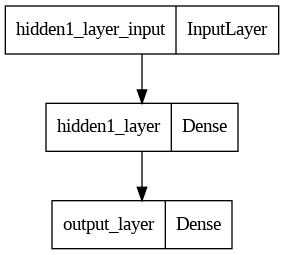

In [ ]:
n_input = X_train.shape[1]      # Celdas en la capa de entrada (variables de entrada)
n_hidden1 = 20   # Celdas en la capa oculta
n_output =3     # Celdas en la capa de salida (un valor numérico)

# Definir las capas del modelo
model = Sequential()
model.add(Dense(n_hidden1, input_dim=n_input, activation='relu', 
                name="hidden1_layer"))
model.add(Dense(n_output, name="output_layer"))

# Learning rate del modelo.
learning_rate = 0.001 

# Definir el optimizador a utilizar (SGD, descenso del gradiente estocástico)
sgd = SGD(lr=learning_rate)

# Compilar el modelo indicando la función de pérdida (loss) y el optimizador
model.compile(loss='categorical_crossentropy',                  # función de pérdida para problemas de clasificación multi-clase
              optimizer=optimizers.Adam(learning_rate=learning_rate),  # optimizador Adam
              metrics=['accuracy'])

model.summary()

# Obtener un fichero con la representación gráfica del modelo
plot_model(model, to_file='model.png')

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Error cuadrático medio')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Error (loss) en entrenamiento')
  plt.legend()
  plt.ylim([0, max(1,max(np.array(history.history['loss'])))])

In [ ]:
Y_train

0       TEAM1WINS
1       TEAM1WINS
2       TEAM2WINS
3       TEAM1WINS
4       TEAM2WINS
          ...    
1371    TEAM2WINS
1372    TEAM2WINS
1373    TEAM2WINS
1374    TEAM1WINS
1375    TEAM1WINS
Name: GOALS_DIFF, Length: 1376, dtype: object

In [ ]:
batch = 20    # Tamaño del batch
n_epochs = 300 # Número de epochs

#Entrenar el modelo a partir de los ejemplos de TRAIN creados en el punto 2
history = model.fit(X_train_std, to_categorical(Y_train), batch_size=batch, epochs=n_epochs, verbose=0 )

plot_history(history)
traza_train = np.array(history.history['loss'])
print("-- Mínimo error TRAIN: {:.6f}".format(min(traza_train)))
print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_train[-10:])))
print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_train[-10:])))

TypeError: ignored

In [ ]:
results = model.evaluate(X_test_std, to_categorical(Y_test), batch_size=10)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 9ms/step - loss: 5.1985 - accuracy: 0.2500
test loss, test acc: [5.198546409606934, 0.25]
